In [1]:
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from tqdm import tqdm

from pandas.api.types import CategoricalDtype
from ast import literal_eval

np.random.seed(7)

In [2]:
train_loc = pd.read_csv('/home/felix/Downloads/train_locations.csv')
train_cus = pd.read_csv('/home/felix/Downloads/train_customers.csv', parse_dates=['created_at', 'updated_at'])
test_loc = pd.read_csv('/home/felix/Downloads/test_locations.csv')
test_cus = pd.read_csv('/home/felix/Downloads/test_customers.csv', parse_dates=['created_at', 'updated_at'])
vendor = pd.read_csv('/home/felix/Downloads/vendors.csv', parse_dates=['created_at', 'updated_at'])
order = pd.read_csv('/home/felix/Downloads/orders.csv')
submissions = pd.read_csv('/home/felix/Downloads/SampleSubmission (1).csv')

/home/felix/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
order.head()

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,163238.0,92PEE24,1.0,7.6,2,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,105,2019-08-01 05:30:16,0,NaN,92PEE24 X 0 X 105
1,163240.0,QS68UD8,1.0,8.7,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,294,2019-08-01 05:31:10,0,Work,QS68UD8 X 0 X 294
2,163241.0,MB7VY5F,2.0,14.4,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:31:33,0,NaN,MB7VY5F X 0 X 83
3,163244.0,KDJ951Y,1.0,7.1,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,90,2019-08-01 05:34:54,0,Home,KDJ951Y X 0 X 90
4,163245.0,BAL0RVT,4.0,27.2,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:35:51,0,Work,BAL0RVT X 0 X 83


In [12]:
def percent_missing(df):
    data = pd.DataFrame(df)
    df__cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update ({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100, 2)})
    return  dict_x
df_cols = order.columns


missing = percent_missing(order)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)

print('percent of missing data')
df_miss[0:60]
    

percent of missing data


[('promo_code', 96.82),
 ('delivery_time', 96.21),
 ('delivery_date', 73.73),
 ('vendor_rating', 66.58),
 ('driver_accepted_time', 65.66),
 ('promo_code_discount_percentage', 51.31),
 ('preparationtime', 41.06),
 ('picked_up_time', 38.02),
 ('ready_for_pickup_time', 37.73),
 ('delivered_time', 36.63),
 ('LOCATION_TYPE', 36.14),
 ('order_accepted_time', 35.73),
 ('is_favorite', 26.01),
 ('item_count', 5.12),
 ('akeed_order_id', 0.05),
 ('customer_id', 0.0),
 ('grand_total', 0.0),
 ('payment_mode', 0.0),
 ('vendor_discount_amount', 0.0),
 ('is_rated', 0.0),
 ('driver_rating', 0.0),
 ('deliverydistance', 0.0),
 ('vendor_id', 0.0),
 ('created_at', 0.0),
 ('LOCATION_NUMBER', 0.0),
 ('CID X LOC_NUM X VENDOR', 0.0)]

In [3]:
train_loc = train_loc.drop(columns=['latitude', 'longitude'])
train_cus = train_cus.drop(columns=['language', 'dob', 'created_at', 'updated_at'])
train_cus = train_cus.drop_duplicates()

test_loc = test_loc.drop(columns=['latitude', 'longitude'])
test_cus = test_cus.drop(columns=['language', 'dob', 'created_at', 'updated_at'])
test_cus = test_cus.drop_duplicates()

vendor = vendor[['id', 'latitude', 'longitude', 'vendor_category_en', 'delivery_charge', 'serving_distance', 'is_open', 'prepration_time', 'discount_percentage', 'status', 'verified', 'rank', 'vendor_rating', 'primary_tags']]

order = order[['akeed_order_id', 'customer_id', 'item_count', 'grand_total', 'payment_mode', 'vendor_discount_amount', 'promo_code_discount_percentage', 'is_favorite', 'is_rated', 'vendor_rating', 'driver_rating', 'deliverydistance', 'preparationtime', 'vendor_id', 'LOCATION_NUMBER', 'CID X LOC_NUM X VENDOR']]
order = order.drop_duplicates(['CID X LOC_NUM X VENDOR'])

In [4]:
train_cus = train_cus.rename({'akeed_customer_id':'CID'}, axis=1)
train_loc = train_loc.rename({'customer_id': 'CID', 'location_number':'LOC_NUM'}, axis=1)

test_cus = test_cus.rename({'akeed_customer_id':'CID'}, axis=1)
test_loc = test_loc.rename({'customer_id': 'CID', 'location_number':'LOC_NUM'}, axis=1)

vendor = vendor.rename({'id':'VENDOR'}, axis=1)

order = order.rename({'customer_id':'CID', 'vendor_id':'VENDOR', 'LOCATION_NUMBER':'LOC_NUM'}, axis=1)

In [5]:
train = pd.merge(train_cus, train_loc, on='CID', how='left')
test = pd.merge(test_cus, test_loc, on='CID', how='left')

In [7]:
train.head()

(       CID gender  status  verified  LOC_NUM location_type
 0  TCHWPBT   Male       1         1        0          Work
 1  TCHWPBT   Male       1         1        1          Home
 2  TCHWPBT   Male       1         1        2           NaN
 3  ZGFSYCZ   Male       1         1        0          Home
 4  ZGFSYCZ   Male       1         1        1          Home, (58089, 6))

In [8]:
test.head()

(       CID gender  status  verified  LOC_NUM location_type
 0  ICE2DJP   Male       1         1        0           NaN
 1  ICE2DJP   Male       1         1        1           NaN
 2  ICE2DJP   Male       1         1        2         Other
 3  ICE2DJP   Male       1         1        3         Other
 4  ICE2DJP   Male       1         1        4          Work, (16328, 6))

In [9]:
vendor.head()

,VENDOR,latitude,longitude,vendor_category_en,delivery_charge,serving_distance,is_open,prepration_time,discount_percentage,status,verified,rank,vendor_rating,primary_tags
0,4,-0.588596,0.754434,Restaurants,0.0,6.0,1.0,15,0.0,1.0,1,11,4.4,"{""primary_tags"":""4""}"
1,13,-0.471654,0.744470,Restaurants,0.7,5.0,1.0,14,0.0,1.0,1,11,4.7,"{""primary_tags"":""7""}"
2,20,-0.407527,0.643681,Restaurants,0.0,8.0,1.0,19,0.0,1.0,1,1,4.5,"{""primary_tags"":""71""}"
3,23,-0.585385,0.753811,Restaurants,0.0,5.0,1.0,16,0.0,1.0,1,11,4.5,"{""primary_tags"":""46""}"
4,28,0.480602,0.552850,Restaurants,0.7,15.0,1.0,10,0.0,1.0,1,11,4.4,"{""primary_tags"":""32""}"


In [10]:
order.head()

,akeed_order_id,CID,item_count,grand_total,payment_mode,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,vendor_rating,driver_rating,deliverydistance,preparationtime,VENDOR,LOC_NUM,CID X LOC_NUM X VENDOR
0,163238.0,92PEE24,1.0,7.6,2,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,105,0,92PEE24 X 0 X 105
1,163240.0,QS68UD8,1.0,8.7,1,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,294,0,QS68UD8 X 0 X 294
2,163241.0,MB7VY5F,2.0,14.4,1,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,83,0,MB7VY5F X 0 X 83
3,163244.0,KDJ951Y,1.0,7.1,1,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,90,0,KDJ951Y X 0 X 90
4,163245.0,BAL0RVT,4.0,27.2,1,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,83,0,BAL0RVT X 0 X 83


In [11]:
train.shape, test.shape, vendor.shape, order.shape

((58089, 6), (16328, 6), (100, 14), (80142, 16))

In [12]:
print(train['gender'].value_counts())
print('----------------------------------------')
print(train['status'].value_counts())
print('----------------------------------------')
print(train['verified'].value_counts())
print('----------------------------------------')
print(train['LOC_NUM'].value_counts())
print('----------------------------------------')
print(train['location_type'].value_counts())
print('----------------------------------------')
print(test['gender'].value_counts())
print('----------------------------------------')
print(test['status'].value_counts())
print('----------------------------------------')
print(test['verified'].value_counts())
print('----------------------------------------')
print(test['LOC_NUM'].value_counts())
print('----------------------------------------')
print(test['location_type'].value_counts())

Male          34540
male           3394
Female         3040
Female           26
Male             20
Female            6
Female            5
                  3
Female            2
?????             2
Name: gender, dtype: int64
----------------------------------------
1    58037
0       52
Name: status, dtype: int64
----------------------------------------
1    56372
0     1717
Name: verified, dtype: int64
----------------------------------------
0     34575
1     13469
2      5356
3      2459
4      1125
5       489
6       240
7       127
8        75
9        51
10       33
11       20
12       14
13       12
14       12
15        7
16        5
17        4
18        4
19        2
28        1
20        1
21        1
22        1
23        1
24        1
25        1
26        1
27        1
29        1
Name: LOC_NUM, dtype: int64
----------------------------------------
Home     19244
Work      6284
Other     5996
Name: location_type, dtype: int64
----------------------------------------
M

In [13]:
train['gender'] = train['gender'].replace(['Male', 'male', 'Male ','Male  ', '  ', '?????'], 'Male')
train['gender'] = train['gender'].replace(['Female', 'Female ', 'Female  ', 'Female   ', 'Female    '], 'Female')
train['gender'] = train['gender'].fillna('Male')

test['gender'] = test['gender'].replace(['Male', 'male', 'Male ','Male  ', '  ', '?????'], 'Male')
test['gender'] = test['gender'].replace(['Female', 'Female ', 'Female  ', 'Female   ', 'Female    '], 'Female')
test['gender'] = test['gender'].fillna('Male')

In [14]:
train['LOC_NUM'] = train['LOC_NUM'].astype('category')
train['gender'] = train['gender'].astype('category')

test['LOC_NUM'] = test['LOC_NUM'].astype('category')
test['gender'] = test['gender'].astype('category')

vendor['vendor_category_en'] = vendor['vendor_category_en'].astype('category')
vendor['is_open'] = vendor['is_open'].astype('category')

order['payment_mode'] = order['payment_mode'].astype('category')
order['is_favorite'] = order['is_favorite'].astype('category')
order['is_rated'] = order['is_rated'].astype('category')
order['VENDOR'] = order['VENDOR'].astype('category')
order['LOC_NUM'] = order['LOC_NUM'].astype('category')

In [28]:
cat_type = CategoricalDtype(categories=[0, 1], ordered=True)
cat_type2 = CategoricalDtype(categories=[1,11], ordered=True)

train['status'] = train['status'].astype(cat_type)
train['verified'] = train['verified'].astype(cat_type)
train['location_type'] = train['location_type'].astype('category')
test['status'] = test['status'].astype(cat_type)
test['verified'] = test['verified'].astype(cat_type)
test['location_type'] = test['location_type'].astype('category')
vendor['status'] = vendor['status'].astype(cat_type)
vendor['verified'] = vendor['verified'].astype(cat_type)
vendor['rank'] = vendor['rank'].astype(cat_type2)

In [16]:
train.dtypes

CID                object
gender           category
status           category
verified         category
LOC_NUM          category
location_type      object
dtype: object

In [ ]:
train.head()

In [17]:
vendor.dtypes

VENDOR                    int64
latitude                float64
longitude               float64
vendor_category_en     category
delivery_charge         float64
serving_distance        float64
is_open                category
prepration_time           int64
discount_percentage     float64
status                 category
verified               category
rank                   category
vendor_rating           float64
primary_tags             object
dtype: object

In [ ]:
vendor.head()

In [18]:
vendor['primary_tags'] = vendor['primary_tags'].fillna('[]')
vendor['primary_tags'] = vendor['primary_tags'].apply(literal_eval)
vendor['primary_tags'] = vendor['primary_tags'].str.get('primary_tags')

In [19]:
vendor.head()

,VENDOR,latitude,longitude,vendor_category_en,delivery_charge,serving_distance,is_open,prepration_time,discount_percentage,status,verified,rank,vendor_rating,primary_tags
0,4,-0.588596,0.754434,Restaurants,0.0,6.0,1.0,15,0.0,1,1,11,4.4,4
1,13,-0.471654,0.744470,Restaurants,0.7,5.0,1.0,14,0.0,1,1,11,4.7,7
2,20,-0.407527,0.643681,Restaurants,0.0,8.0,1.0,19,0.0,1,1,1,4.5,71
3,23,-0.585385,0.753811,Restaurants,0.0,5.0,1.0,16,0.0,1,1,11,4.5,46
4,28,0.480602,0.552850,Restaurants,0.7,15.0,1.0,10,0.0,1,1,11,4.4,32


In [37]:
def percent_missing(df):
    data = pd.DataFrame(df)
    df__cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update ({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100, 2)})
    return  dict_x
df_cols = order.columns


missing = percent_missing(order)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)

print('percent of missing data')
df_miss[0:17]
    

percent of missing data


[('akeed_order_id', 0.0),
 ('CID', 0.0),
 ('item_count', 0.0),
 ('grand_total', 0.0),
 ('payment_mode', 0.0),
 ('vendor_discount_amount', 0.0),
 ('promo_code_discount_percentage', 0.0),
 ('is_favorite', 0.0),
 ('is_rated', 0.0),
 ('vendor_rating', 0.0),
 ('driver_rating', 0.0),
 ('deliverydistance', 0.0),
 ('preparationtime', 0.0),
 ('VENDOR', 0.0),
 ('LOC_NUM', 0.0),
 ('CID X LOC_NUM X VENDOR', 0.0)]

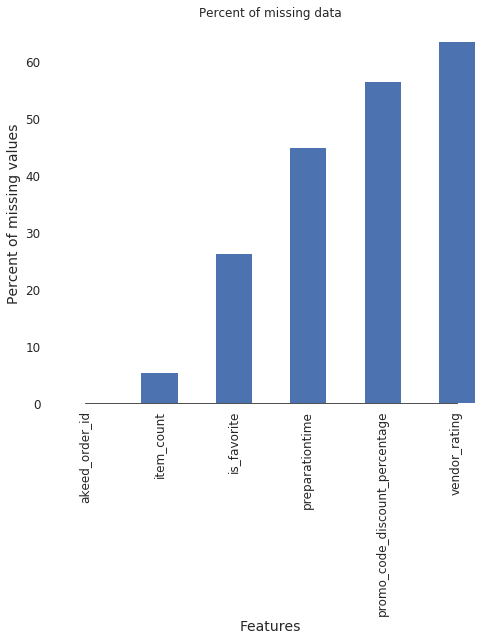

In [21]:
sns.set_style('white')
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(order.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='b')

ax.xaxis.grid(False)
ax.set(ylabel='Percent of missing values')
ax.set(xlabel='Features')
ax.set(title='Percent of missing data')
sns.despine(trim=True, left=True)

In [22]:
def handl_miss(ordr):
    ordr['akeed_order_id'] = order['akeed_order_id'].interpolate()
    ordr['item_count'] = order['item_count'].fillna(1)
    ordr['is_favorite'] = order['is_favorite'].fillna('No')
    ordr['LOC_NUM'] = order['LOC_NUM'].interpolate(method='pad')
    ordr['preparationtime'] = order['preparationtime'].fillna(40)
    ordr['promo_code_discount_percentage'] = order['promo_code_discount_percentage'].fillna(0)
    ordr['vendor_rating'] = order['vendor_rating'].fillna(order['vendor_rating'].median())
    return ordr

In [23]:
order = handl_miss(order)

In [24]:
missing = percent_missing(order)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('percent of missing data')
df_miss[0:17]

percent of missing data


[('akeed_order_id', 0.0),
 ('CID', 0.0),
 ('item_count', 0.0),
 ('grand_total', 0.0),
 ('payment_mode', 0.0),
 ('vendor_discount_amount', 0.0),
 ('promo_code_discount_percentage', 0.0),
 ('is_favorite', 0.0),
 ('is_rated', 0.0),
 ('vendor_rating', 0.0),
 ('driver_rating', 0.0),
 ('deliverydistance', 0.0),
 ('preparationtime', 0.0),
 ('VENDOR', 0.0),
 ('LOC_NUM', 0.0),
 ('CID X LOC_NUM X VENDOR', 0.0)]

In [31]:
train.head()

,CID,gender,status,verified,LOC_NUM,location_type
0,TCHWPBT,Male,1,1,0,Work
1,TCHWPBT,Male,1,1,1,Home
2,TCHWPBT,Male,1,1,2,NaN
3,ZGFSYCZ,Male,1,1,0,Home
4,ZGFSYCZ,Male,1,1,1,Home


In [29]:
train.dtypes

CID                object
gender           category
status           category
verified         category
LOC_NUM          category
location_type    category
dtype: object

In [30]:
test.head()

,CID,gender,status,verified,LOC_NUM,location_type
0,ICE2DJP,Male,1,1,0,NaN
1,ICE2DJP,Male,1,1,1,NaN
2,ICE2DJP,Male,1,1,2,Other
3,ICE2DJP,Male,1,1,3,Other
4,ICE2DJP,Male,1,1,4,Work


In [32]:
test.dtypes

CID                object
gender           category
status           category
verified         category
LOC_NUM          category
location_type    category
dtype: object

In [33]:
vendor.head()

,VENDOR,latitude,longitude,vendor_category_en,delivery_charge,serving_distance,is_open,prepration_time,discount_percentage,status,verified,rank,vendor_rating,primary_tags
0,4,-0.588596,0.754434,Restaurants,0.0,6.0,1.0,15,0.0,1,1,11,4.4,4
1,13,-0.471654,0.744470,Restaurants,0.7,5.0,1.0,14,0.0,1,1,11,4.7,7
2,20,-0.407527,0.643681,Restaurants,0.0,8.0,1.0,19,0.0,1,1,1,4.5,71
3,23,-0.585385,0.753811,Restaurants,0.0,5.0,1.0,16,0.0,1,1,11,4.5,46
4,28,0.480602,0.552850,Restaurants,0.7,15.0,1.0,10,0.0,1,1,11,4.4,32


In [34]:
vendor.dtypes

VENDOR                    int64
latitude                float64
longitude               float64
vendor_category_en     category
delivery_charge         float64
serving_distance        float64
is_open                category
prepration_time           int64
discount_percentage     float64
status                 category
verified               category
rank                   category
vendor_rating           float64
primary_tags             object
dtype: object

In [35]:
order.head()

,akeed_order_id,CID,item_count,grand_total,payment_mode,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,vendor_rating,driver_rating,deliverydistance,preparationtime,VENDOR,LOC_NUM,CID X LOC_NUM X VENDOR
0,163238.0,92PEE24,1.0,7.6,2,0.0,0.0,No,No,0.0,0.0,0.0,40.0,105,0,92PEE24 X 0 X 105
1,163240.0,QS68UD8,1.0,8.7,1,0.0,0.0,No,No,0.0,0.0,0.0,40.0,294,0,QS68UD8 X 0 X 294
2,163241.0,MB7VY5F,2.0,14.4,1,0.0,0.0,No,No,0.0,0.0,0.0,40.0,83,0,MB7VY5F X 0 X 83
3,163244.0,KDJ951Y,1.0,7.1,1,0.0,0.0,No,No,0.0,0.0,0.0,40.0,90,0,KDJ951Y X 0 X 90
4,163245.0,BAL0RVT,4.0,27.2,1,0.0,0.0,No,No,0.0,0.0,0.0,40.0,83,0,BAL0RVT X 0 X 83


In [36]:
test['location_type'] = test['location_type'].interpolate(method='pad')
test['location_type'] = test['location_type'].fillna('Other')

train['location_type'] = train['location_type'].fillna('Other')

In [43]:
train.isnull().sum(), test.isnull().sum(), vendor.isnull().sum(), order.isnull().sum()

(CID              0
 gender           0
 status           0
 verified         0
 LOC_NUM          0
 location_type    0
 dtype: int64, CID              0
 gender           0
 status           0
 verified         0
 LOC_NUM          0
 location_type    0
 dtype: int64, VENDOR                  0
 latitude                0
 longitude               0
 vendor_category_en      0
 delivery_charge         0
 serving_distance        0
 is_open                 0
 prepration_time         0
 discount_percentage     0
 status                  0
 verified                0
 rank                    0
 vendor_rating           0
 primary_tags           23
 dtype: int64, akeed_order_id                    0
 CID                               0
 item_count                        0
 grand_total                       0
 payment_mode                      0
 vendor_discount_amount            0
 promo_code_discount_percentage    0
 is_favorite                       0
 is_rated                          0
 vendor

In [46]:
vendor['primary_tags'] = vendor['primary_tags'].fillna(0)

In [49]:
submissions.shape

(1672000, 2)

In [50]:
test = test.assign(key=1).merge(vendor.assign(key=1), on='key').drop('key', axis=1)
train = train.assign(key=1).merge(vendor.assign(key=1), on='key').drop('key', axis=1)

MemoryError: 